<a href="https://colab.research.google.com/github/koh-ts/human_activity_recognition/blob/master/human_activity_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
from sklearn import svm
import pandas_profiling as pdp
from IPython.display import HTML
import lightgbm as lgb
from matplotlib import pyplot as plt
import pickle
%matplotlib inline

Mount your Google Drive. In this notebook, we assume that 'report2' folder is placed directly under 'My Drive'.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load the data.

In [0]:
root_dir="/content/drive/My Drive/report2/"
nsample = 3000

xraw_train = pd.read_csv(root_dir+"X_train.csv",header=None)
yraw_train = pd.read_csv(root_dir+"y_train.csv",header=None)
xraw_test = pd.read_csv(root_dir+"X_test.csv",header=None)

In [0]:
# with open(root_dir + 'corr.txt') as f:
#   lines = f.readlines()
# lis = []
# for l in lines:
#   for i, c in enumerate(l):
#     if c == 'i':
#       num = int(l[:i - 1])
#       break
#   lis.append(num)

In [0]:
# with open(root_dir + 'corr_done.txt', 'wb') as f:
#   pickle.dump(lis, f)

In [0]:
with open(root_dir + 'corr_done.txt', 'rb') as f:
  lis = pickle.load(f)

In [0]:
xraw_train = xraw_train.drop(lis, axis=1)
xraw_test = xraw_test.drop(lis, axis=1)

In [9]:
X_train = np.array(xraw_train)
y_train = np.array(yraw_train.ix[:,0])
X_test = np.array(xraw_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  


In [0]:
XTrain = X_train[:nsample,:] #use the first 3000 samples for training
yTrain = y_train[:nsample]
XVal = X_train[nsample:,:] #use the rests for validation
yVal = y_train[nsample:]
alldata = pd.concat([xraw_train, xraw_test], ignore_index=True)

In [0]:
# profile1 = pdp.ProfileReport(alldata)
# profile1.to_file(outputfile="myoutputfile1.html")
# HTML(filename="myoutputfile1.html")

Train a linear SVM classifier

In [13]:
print("Training linear SVM classifier.")
clf = svm.LinearSVC()
clf.fit(XTrain,yTrain)

Training linear SVM classifier.


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

Evaluate training end validation scores.

In [14]:
yHatTrain = clf.predict(XTrain)
yHatVal = clf.predict(XVal)
print("Training score ", len((np.where(yHatTrain == yTrain))[0])*1.0/XTrain.shape[0])
print("Validation score ", len((np.where(yHatVal == yVal))[0])*1.0/XVal.shape[0])

Training score  0.9953333333333333
Validation score  0.9134615384615384


In [0]:
train_data_set = lgb.Dataset(XTrain, yTrain)
valid_data_set = lgb.Dataset(XVal, yVal, reference=train_data_set)

params = {'boosting_type': 'gbdt',
          'objective': 'multiclass',
          'num_class': 7,
          'metric': {'multi_error'},
          'num_leaves': 32,
          'learning_rate': 0.05,
          'feature_fraction': 0.9, #0.9
          'bagging_fraction': 0.8, #0.8
          'bagging_freq': 7}

In [24]:
gbm = lgb.train(params, train_data_set, num_boost_round=300, valid_sets=[train_data_set, valid_data_set], early_stopping_rounds=100)

[1]	training's multi_error: 0.483333	valid_1's multi_error: 0.571635
Training until validation scores don't improve for 100 rounds.
[2]	training's multi_error: 0.139667	valid_1's multi_error: 0.320192
[3]	training's multi_error: 0.0443333	valid_1's multi_error: 0.207212
[4]	training's multi_error: 0.0286667	valid_1's multi_error: 0.192788
[5]	training's multi_error: 0.0253333	valid_1's multi_error: 0.184135
[6]	training's multi_error: 0.02	valid_1's multi_error: 0.176442
[7]	training's multi_error: 0.0183333	valid_1's multi_error: 0.173077
[8]	training's multi_error: 0.015	valid_1's multi_error: 0.167788
[9]	training's multi_error: 0.0156667	valid_1's multi_error: 0.164423
[10]	training's multi_error: 0.0146667	valid_1's multi_error: 0.160096
[11]	training's multi_error: 0.0146667	valid_1's multi_error: 0.157212
[12]	training's multi_error: 0.0133333	valid_1's multi_error: 0.157212
[13]	training's multi_error: 0.0133333	valid_1's multi_error: 0.160096
[14]	training's multi_error: 0.012

Predict test data and save the result.

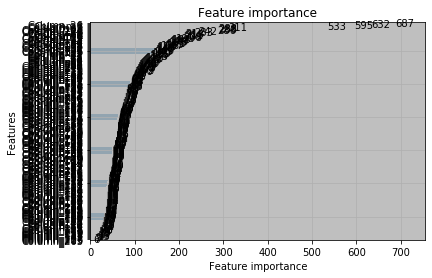

In [25]:
lgb.plot_importance(gbm)
plt.show()

In [0]:
yHatTest_gbm_raw = gbm.predict(X_test)
yHatTest_gbm = np.argmax(yHatTest_gbm_raw, axis=1)
np.savetxt(root_dir+'result_gbm2.txt', yHatTest_gbm)

In [0]:
yHatTest = clf.predict(X_test)
np.savetxt(root_dir+'result_svm.txt', yHatTest)